# normalizing data to mitigate overfitting

If you can't collect more data to mitigate model overfitting, it might be beneficial to 'normalize' the data that you do have.

There are lots of different ways to normalize data. The most common approaches attempt to transform the data in some way so that mean of each explanatory variable is close to zero, and the standard deviation of each explanatory variable is close to one.

In general, transforming an explanatory variable so it has a mean of zero is referred to as "centering", and transforming the explanatory variable to have a standard deviation of one is referred to as "scaling".

The most straight-forward way to transform an explanatory variable so that it is "centered" is to subtract the mean value over all data samples from each value. In other words, you calculate the mean value of a column over all rows in the data table, and then subtract that value from each row's value in that column. This sets the mean value of the *transformed* data to zero, with values larger than the mean (in the untransformed data) being positive, and values smaller than the mean being negative.

The easiest way to transform an explanatory variable to be "scaled" is to divide each value by the *standard deviation* across all values. This effectively 'scales' the data to be in 'units' of standard deviation. Scaling data can be absolutely *critical* if your explanatory variables are on radically different natural scales, to begin with. Under these conditions, variables that are naturally *larger* (in absolute value) will dominate, and variables that are on smaller natural scales will make little impact on your results. Re-scaling the data helps ensure that *all* potential explanatory variables have a chance to contribute!

## normalizing data as part of the model

Traditionally, data normalization and any other data transformations are applied to the input data *before* the data are supplied to the statistical model.

However, the neural network framework makes it very convenient to incorporate data normalization into the model, itself. This approach has at least three advantages, compared to normalizing the data as a separate pre-processing step.

1.  If the model incorporates all normalization, you can apply it directly to new raw data samples, without having to pre-normalize new data. This can both reduce potential errors down the road (shoot, I forgot to normalize this new data!) *and* make it much easier to deploy trained models in the field, because you don't have to *also* deploy a *separate* data normalization process.
2.  Incorporating normalization into the model allows the model to 'learn' how to best normalize the data during the training process, rather than having to specify all data normalization *before* training begins. This does also come with the downside of adding more parameters to the model to 'fit' the data normalization, but these additional parameters are typically very few.
3.  Incorporating normalization into the model means that you can normalize *any* feature of the model, not *just* the input data. Normalization can be applied to *any* neural network layer's output, either before or after nonlinear activation. This can help to more effectively prevent overfitting in very deep neural networks with hundreds of layers or more.

## batch normalization

There are quite a few different normalization methods commonly used in neural networks. One of the most common is called "batch normalization".

Remember how neural network training typically uses 'batches' of training data?

During each step of training, the network is supplied with a 'batch' of data (typically between 32 and 512 data samples). The training process uses the batch of data to calculate gradients and update the parameters of the model, which is typically more accurate than trying to estimate gradients and parameter updates from a single data sample.

"Batch normalization" leverages the batches of data used during batch training to estimate new model parameters used to normalize the input data, or whatever input is supplied to the batch normalization process.

Remember how traditional data normalization uses the data's mean and standard deviation to "center" and "scale" the explanatory variables, respectively?

Well, batch normalization uses a "batch" of training data to do the same thing!

Just like you can use the *entire* training data set to calculate the mean and standard deviation of each explanatory variable, and use these to center and scale the data. You can also use a *batch* of training data to calculate the mean and standard deviation of each explanatory variable, and use these 'batch' values to center and scale the input data.

Commonly-used batch normalization methods are bit more sophisticated than this straight-forward approach. They typically keep a 'running average' of mean and standard-deviation values seen over individual batches during training, and they can include additional 'bells and whistles' like 'momentum'. But basically, batch normalization is a fairly straight-forward approach for incorporating data normalization methods into neural network models.

In the below code cell, we simulate a linear data set of 100 samples with 2 explanatory variables and a single response variable.

We split the data set into 60% training and 40% validation data, and we train a complex neural network for 500 epochs using a batch size of 10, stochastic gradient descent optimization and mean squared error loss. This should look familiar; we expect our model to overfit.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 3s 93ms/step - loss: 1.4309 - val_loss: 0.9894
Epoch 2/500
6/6 [==============================] - 0s 7m

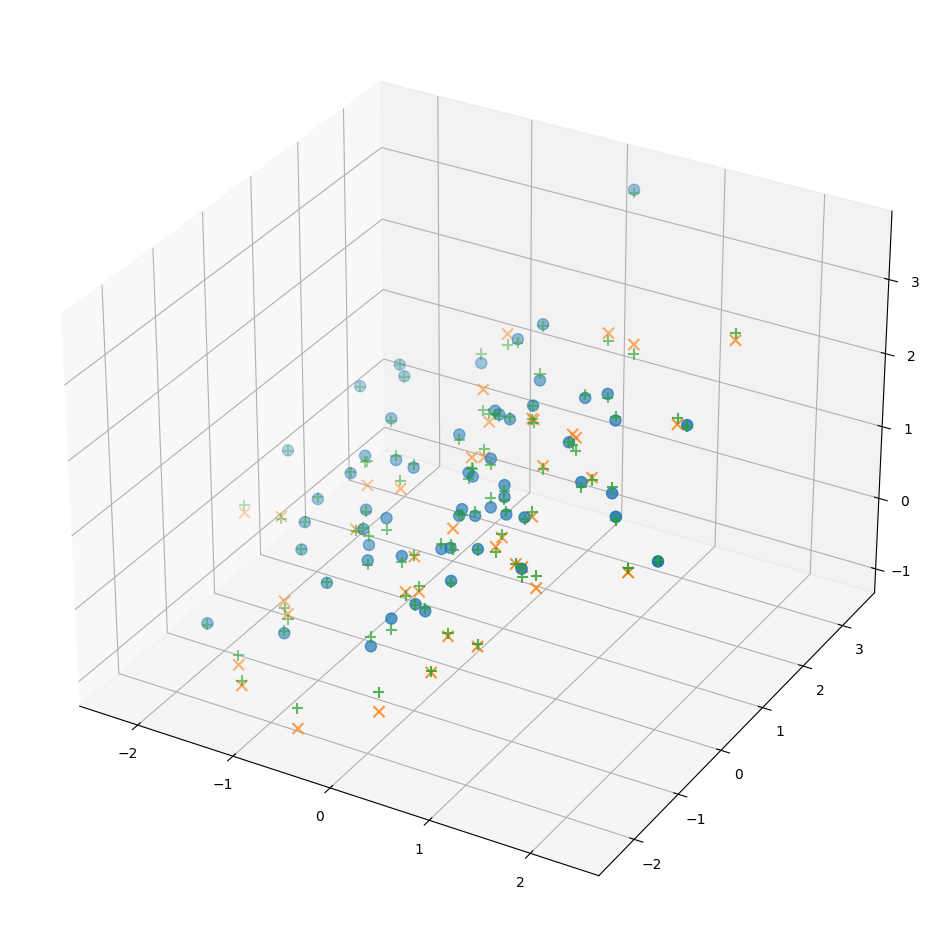

In [1]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

As expected, by the end of the training process the model's loss on the training data is much less than its loss on the validation data, a sure sign of overfitting.

Let's try to fix this problem by using batch normalization to normalize our input data *before* it is processed by the first layer in the model.

To do this, we'll have to use a *new* layer as the first layer in the model.

Tensorflow implements batch normalization as a keras layer, just like the Dense layer objects we have been using to build neural network layers.

The tf.keras.layers.BatchNormalization object implements batch normalization as part of a neural network. One of the very nice things about the keras framework is that it allows us to do many different *types* of processing using the *same* programming interface. So, rather than having to learn an entirely *new* way to normalize our input data, we can just use a BatchNormalizaiton layer as the *first* layer in our network, and it will normalize any input data for us 'on the fly'.

Although we can *use* a BatchNormalizaiton object just like any neural network layer, BatchNormalizaiton *doesn't* have any 'neurons' in it, and it doesn't function like a typical neural network layer. BatchNormalization just normalizes our input data, or whatever input we provide it with.

BatchNormalization *does* add a few trainable parameters to our model, because it has to 'learn' how to transform the input data. However, in the context of a large neural network, the increase in trainable prameters from adding BatchNormalization is negligible. In the code cell below, BatchNormalization adds 8 parameters to the model's existing parameter count of 8,577, and 4 of those parameters are not trainable (you can see this by observing the model's summary).

For each explanatory variable (there are 2 in our data), the BatchNormalization layer needs to learn the 'mean' and 'standard deviation' to center and scale the data, respectively. We 'could' just do these calculations separately for each batch of data, in which case we wouldn't need *any* new model parameters, but it's typically better to allow the model to incorporate information from *many* training batches to center and scale the data, even with the additional cost of 2 trainable parameters per explanatory variable. The other additional parameters - which are not trainable but set at the beginning of training to default values - control *how* the BatchNormalization layer integrates information across training batches.

To change our model to use batch normalization on the *input* data, we need to set the *first* layer in the network to be a BatchNormalization layer. To do this, we specify:

    model.add(tf.keras.layers.BatchNormalization(input_shape=[2]))

as the *first* call to the model.add(...) function. (line 26 in the following code cell).

You'll also notice that we need to *remove* the:

    input_shape=[2]

from the first Dense layer in the new model (now on line 27), because we can *only* specify the "input_shape" option for the *first* layer in the network.

That's it; now we have batch normalization normalizing our model's input data. The rest of the model, and the training process, remains the same.

Let's run the following code cell and see if batch normalization of our input data can help mitigate model overfitting.

In [ ]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

The graph is really not much help. Maybe you can convince yourself that the green + (model fit) are typically not 'as close to' the blue circles (training data) as in the previous "overfitting" model, but it's really hard to tell objectively.

You can compare the 'normalized' model's training loss to its validation loss, though! Are they more 'similar', now that we've normalized our data?

Remember that, in this case, we have the *same* amount of training and validation data as before, when the model was overfitting the training data. We've also *increased* the number of parameters in the model, which we would typically expect to *exacerbate* any overfitting problems!

Remember that you can add BatchNormalization layers after *any* layer in the network (except the output layer!), in which case the output of the *previous* layer will be centered and scaled. Perhaps (after completing the quiz), you might like to try adding BatchNormalization layers at different points in the neural network, and observe the impact on model overfitting.